In [38]:
import csv
import pandas

import os 
from pathlib import Path

cwd = Path(os.getcwd())
print("cwd: " + str(cwd))

data_file = cwd.parents[1] / 'data' / 'TraderLedger' / 'ledger.csv'
print(data_file)

cwd: /Users/vrajpandya/repo/OpenTrader/lab/Notebooks
/Users/vrajpandya/repo/OpenTrader/data/TraderLedger/ledger.csv


In [10]:
df = pandas.read_csv(data_file)

df.head()

,EntryID,OrderID,ClientID,Action,TotalQuantity,LimitPrice,TimeInForce,FilledQuantity,Symbol,Exchange,Currency,ExecutionID,ExecTime,AvgPrice,ExecutionSide,Commission,RealizedPNL,CommissionCurrency,Yield
0,0,3,0,BUY,0.003720,26888.0,Minutes,0.003720,BTC,SMART,USD,0,NaN,26870.0000,BOT,0.4,0,USD,0.0
1,1,4,0,BUY,0.003721,26878.0,Minutes,0.003721,BTC,SMART,USD,1,NaN,26875.8750,BOT,0.4,0,USD,0.0
2,2,5,0,BUY,0.003722,26868.0,Minutes,0.003722,BTC,SMART,USD,2,NaN,26862.9375,BOT,0.4,0,USD,0.0
3,3,6,0,BUY,0.003717,26908.0,Minutes,0.003717,BTC,SMART,USD,3,NaN,26898.6875,BOT,0.4,0,USD,0.0
4,4,7,0,BUY,0.003715,26918.0,Minutes,0.003715,BTC,SMART,USD,4,NaN,26917.1250,BOT,0.4,0,USD,0.0


In [11]:
import pymongo

# Establish a connection to the MongoDB server
client = pymongo.MongoClient("mongodb://localhost:27017/")

# Access the trader_test_db database
db = client["trader_test_db"]

# Access the ConstantStepOffset_27888_10 collection
collection = db["ConstantStepOffset_27888_10"]

# Get all documents in the collection
docs = list(collection.find())

# Convert the list to a dictionary with indices as keys
docs_dict = {i: doc for i, doc in enumerate(docs)}

# Print an example document
print(docs_dict[0])

{'_id': ObjectId('65f63eba9851a426f91b5a2b'), 'baseline': 27888, 'step': 10, 'entry_context': {'order_id': 3, 'entry_id': 0}}


In [13]:
profit = 0

for index, row in df.iterrows():
    if row['Action'] == 'BUY':
        profit -= row['TotalQuantity'] * row['AvgPrice']
    elif row['Action'] == 'SELL':
        profit += row['TotalQuantity'] * row['AvgPrice']
    
    profit -= row['Commission'] * row['TotalQuantity'] * row['AvgPrice']

print(profit)


-17075.551299273604


In [22]:
def calculate_profit_for_config(config_dict):
    baseline = config_dict['baseline']
    stepDelta = config_dict['stepDelta']
    orderQuantityInUSD = config_dict['orderQuantityInUSD']
    executionLimitOffset = config_dict['executionLimitOffset']
    numSteps = int(executionLimitOffset / stepDelta)
    
    
    commission = 0.004
    profit = 0
    
    for step in range(1,numSteps + 1):
        btcQuantity = orderQuantityInUSD / (baseline - (step * stepDelta))
        profit += (baseline + (step * stepDelta)) * btcQuantity
        profit -= orderQuantityInUSD
        profit -= commission * orderQuantityInUSD
    return profit

In [36]:
def num_steps_for_config(config_dict):
    executionLimitOffset = config_dict['executionLimitOffset']
    stepDelta = config_dict['stepDelta']
    return int(executionLimitOffset / stepDelta)

In [35]:
config_dict = {
    "baseline" : 77000,
    "stepDelta": 10,
    "executionLimitOffset": 2000,
    "stateTransitionThreshold": 5,
    "orderQuantityInUSD": 100,
}



print(calculate_profit_for_config(config_dict))

448.92147659150226


In [17]:
print(numSteps * orderQuantityInUSD)

print(100 * (profit) / (numSteps * orderQuantityInUSD))

20000
2.2566079620051642


In [37]:
profit_matrix = [['stepDelta', 'executionLimitOffset', 'orderQuantityInUSD', 'profit', 'maxDrawdown']]

stepDelta_range = range(10, 1000, 10)
executionLimitOffset_range = range(100, 10000, 100)
orderQuantityInUSD_range = range(10, 10000, 10)
for i in stepDelta_range:
    config_dict['stepDelta'] = i
    for j in executionLimitOffset_range:
        config_dict['executionLimitOffset'] = j
        for k in orderQuantityInUSD_range:
            config_dict['orderQuantityInUSD'] = k
            profit = calculate_profit_for_config(config_dict)
            numSteps = num_steps_for_config(config_dict)
            profit_matrix.append([i, j, k, profit, numSteps * k])

profit_df = pandas.DataFrame(profit_matrix)

NameError: name 'pandas' is not defined

In [45]:
profit_df = pandas.DataFrame(data=profit_matrix[1 :], columns=profit_matrix[0]).astype(float)
profit_df.head()

,stepDelta,executionLimitOffset,orderQuantityInUSD,profit,maxDrawdown
0,10.0,100.0,10.0,-0.257013,100.0
1,10.0,100.0,20.0,-0.514026,200.0
2,10.0,100.0,30.0,-0.771039,300.0
3,10.0,100.0,40.0,-1.028051,400.0
4,10.0,100.0,50.0,-1.285064,500.0


<Axes: xlabel='executionLimitOffset', ylabel='profit'>

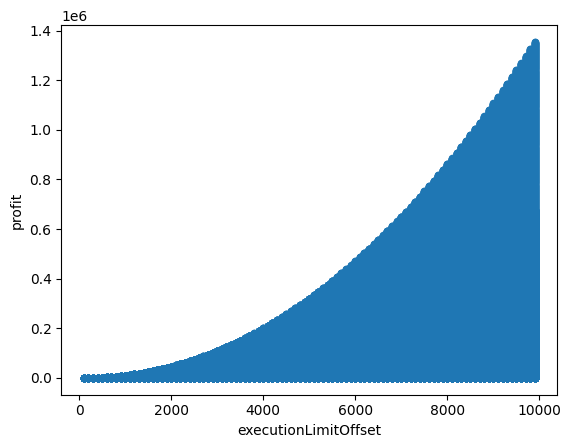

In [47]:

profit_df.plot(x=1, y=3, kind='scatter')


In [50]:
max_profit = profit_df['profit'].max()
max_drawdown = profit_df['maxDrawdown'].max()
print("max Profit: " + str(max_profit))
print("max Drawdown: " + str(max_drawdown))


max Profit: 1354212.1036584158
max Drawdown: 9890100.0


In [61]:
profit_df_less_than_20000 =  profit_df[profit_df['maxDrawdown'] < 20000]

result = profit_df_less_than_20000[profit_df_less_than_20000['profit'] > 3000]



print(result)



         stepDelta  executionLimitOffset  orderQuantityInUSD       profit  \
9790397      990.0                9900.0              1980.0  3001.659832   
9790398      990.0                9900.0              1990.0  3016.819731   

         maxDrawdown  
9790397      19800.0  
9790398      19900.0  


In [ ]:
profit_df_less_than_20000.plot(x=1, y=3, kind='scatter')